In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
!pip install pytrials

import requests
import json
from pytrials.client import ClinicalTrials
import os
import re
from requests.exceptions import ChunkedEncodingError, ConnectionError, Timeout
import time
from tqdm import tqdm
import ast

In [3]:
path_reactions = '/content/drive/My Drive/CSV/reactions.csv'
path_reports = '/content/drive/My Drive/CSV/reports.csv'

df_reactions = pd.read_csv(path_reactions)
df_reports = pd.read_csv(path_reports)

In [4]:
# load all data with alternate drug names
path_acute_myocardial_infarction = '/content/drive/My Drive/CSV/Altdrug/Myocardial_infarction_altdrug.csv'
path_heart_failure = '/content/drive/My Drive/CSV/Altdrug/Heart_failure_altdrug.csv'
path_hypertension = '/content/drive/My Drive/CSV/Altdrug/hypertension_altdrug.csv'
path_ischemic_heart_disease = '/content/drive/My Drive/CSV/Altdrug/ischemic_heart_disease_altdrug.csv'
path_stroke = '/content/drive/My Drive/CSV/Altdrug/stroke_altdrug.csv'
path_COPD = '/content/drive/My Drive/CSV/Altdrug/COPD_altdrug.csv'
path_diabetes = '/content/drive/My Drive/CSV/Altdrug/diabetes_altdrug.csv'
path_asthma = '/content/drive/My Drive/CSV/Altdrug/asthma_altdrug.csv'
path_dementia = '/content/drive/My Drive/CSV/Altdrug/dementia_altdrug.csv'
path_schizophrenia = '/content/drive/My Drive/CSV/Altdrug/schizophrenia_altdrug.csv'
path_epilepsy = '/content/drive/My Drive/CSV/Altdrug/epilepsy_altdrug.csv'
path_multiple_sclerosis = '/content/drive/My Drive/CSV/Altdrug/multiple_sclerosis_altdrug.csv'
path_parkinsonism = '/content/drive/My Drive/CSV/Altdrug/parkinsonism_altdrug.csv'

df_acute_myocardial_infarction = pd.read_csv(path_acute_myocardial_infarction)
df_heart_failure = pd.read_csv(path_heart_failure)
df_hypertension = pd.read_csv(path_hypertension)
df_ischemic_heart_disease = pd.read_csv(path_ischemic_heart_disease)
df_stroke = pd.read_csv(path_stroke)
df_COPD = pd.read_csv(path_COPD)
df_diabetes = pd.read_csv(path_diabetes)
df_asthma = pd.read_csv(path_asthma)
df_dementia = pd.read_csv(path_dementia)
df_schizophrenia = pd.read_csv(path_schizophrenia)
df_epilepsy = pd.read_csv(path_epilepsy)
df_multiple_sclerosis = pd.read_csv(path_multiple_sclerosis)
df_parkinsonism = pd.read_csv(path_parkinsonism)

In [5]:

diseases = {"Myocardial infarction": df_acute_myocardial_infarction,
               "Heart failure":df_heart_failure,
               "Hypertension": df_hypertension,
               "Ischemic heart disease": df_ischemic_heart_disease,
               "Stroke": df_stroke,
               "Chronic obstructive pulmonary disease": df_COPD,
                "Diabetes": df_diabetes,
                "Asthma": df_asthma,
                "Dementia": df_dementia,
                "Schizophrenia": df_schizophrenia,
                "Epilepsy": df_epilepsy,
                "Multiple sclerosis": df_multiple_sclerosis,
                "Parkinson's": df_parkinsonism
              }
data = []

def get_top_effects(df):
  side_effects = df['PT_NAME_ENG'].value_counts().head(5)
  top_5 = side_effects.index.tolist()
  return top_5


for df in diseases.items():

  # indicate the disease name
  disease = df[0]
  df_merged = pd.merge(df_reports, df[1], on='REPORT_ID', how='inner')
  df_merged = pd.merge(df_merged, df_reactions, on='REPORT_ID', how='inner')
  df_merged["INDICATION_NAME_ENG"] = df_merged["INDICATION_NAME_ENG"].str.upper()

  # find all drug - disease pairs
  for drug in df_merged['Alternate drugname'].unique():
    if isinstance(drug, str) and len(drug.strip()) > 0:
      df_filtered  = df_merged[df_merged['Alternate drugname'] == drug]
      df_female = df_filtered[df_filtered['GENDER_ENG'] == 'Female']
      side_effects_female = get_top_effects(df_female)
      df_male = df_filtered[df_filtered['GENDER_ENG'] == 'Male']
      side_effects_male = get_top_effects(df_male)
      total_women = df_filtered[df_filtered['GENDER_ENG'] == 'Female'].shape[0]
      serious_women_count = df_filtered[(df_filtered['GENDER_ENG'] == 'Female') & (df_filtered['SERIOUSNESS_ENG'] == 'Serious')].shape[0]
      # get proportions
      if total_women > 0:
          percentage_serious_women = round((serious_women_count / total_women) * 100, 2)
      else:
          percentage_serious_women = -1.00

      total_men = df_filtered[df_filtered['GENDER_ENG'] == 'Male'].shape[0]
      serious_men_count = df_filtered[(df_filtered['GENDER_ENG'] == 'Male') & (df_filtered['SERIOUSNESS_ENG'] == 'Serious')].shape[0]
      if total_men > 0:
          percentage_serious_men = round((serious_men_count / total_men) * 100,2)
      else:
        percentage_serious_men = -1.00

      if total_women + total_men > 0:
        percent_women = round(total_women / (total_women + total_men) * 100,2)
        percent_men = round(total_men / (total_women + total_men) * 100,2)

      if total_women + total_men > 10:
        # append data to new dataframe if number of reports higher than 10
        data.append({
            'Drug': drug,
            'Indication': disease.upper(),
            'Total Female Reports': total_women,
            'Total Male Reports': total_men,
            'Percentage Female Reports': percent_women,
            'Percentage Male Reports': percent_men,
            'Percentage Serious Female Reports': percentage_serious_women,
            'Percentage Serious Male Reports': percentage_serious_men,
            'Top 5 Side Effects Female': side_effects_female,
            'Top 5 Side Effects Male': side_effects_male
      })

df_data = pd.DataFrame(data)
pd.set_option('display.width', 500)
print(df_data)

# Specify the directory where you want to save the CSV file
# You can set this to any valid path where you have write permissions
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'disease_pair.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
df_data.to_csv(csv_file_path, index=False)
print(f'Results have been exported to {csv_file_path}')

                                   Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male
0                           CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  [Diarrhoea, Spinal epidural haematoma, Myalgia...  [Off label use, Drug ineffective, Dyspnoea, Pr...
1                            METOPROLOL  MYOCARDIAL INFARCTION                    20                 261                       7.12                    92.88                              95.00                            99.62  [Pleural effusion, Death, Headache, Diarrhoea,...  [Dizziness, Diarrhoea, Fall, Hyponatraemia, Po...
2                  

In [6]:
path_acute_myocardial_infarction_pairs = '/content/drive/My Drive/CSV/drug_myocardial_infarction_pair.csv'
path_heart_failure_pairs = '/content/drive/My Drive/CSV/drug_heart_failure_pair.csv'
path_hypertension_pairs = '/content/drive/My Drive/CSV/drug_hypertension_pair.csv'
path_ischemic_heart_disease_pairs = '/content/drive/My Drive/CSV/drug_ischemic_heart_disease_pair.csv'
path_stroke_pairs = '/content/drive/My Drive/CSV/drug_stroke_pair.csv'
path_COPD_pairs = '/content/drive/My Drive/CSV/drug_COPD_pair.csv'
path_diabetes_pairs = '/content/drive/My Drive/CSV/drug_diabetes_pair.csv'
path_asthma_pairs = '/content/drive/My Drive/CSV/drug_asthma_pair.csv'
path_dementia_pairs = '/content/drive/My Drive/CSV/drug_dementia_pair.csv'
path_schizophrenia_pairs = '/content/drive/My Drive/CSV/drug_schizophrenia_pair.csv'
path_epilepsy_pairs = '/content/drive/My Drive/CSV/drug_epilepsy_pair.csv'
path_multiple_sclerosis_pairs = '/content/drive/My Drive/CSV/drug_multiple_sclerosis_pair.csv'
path_parkinsonism_pairs = '/content/drive/My Drive/CSV/drug_parkinsonism_pair.csv'

df_acute_myocardial_infarction_pairs = pd.read_csv(path_acute_myocardial_infarction_pairs)
df_heart_failure_pairs = pd.read_csv(path_heart_failure_pairs)
df_hypertension_pairs = pd.read_csv(path_hypertension_pairs)
df_ischemic_heart_disease_pairs = pd.read_csv(path_ischemic_heart_disease_pairs)
df_stroke_pairs = pd.read_csv(path_stroke_pairs)
df_COPD_pairs = pd.read_csv(path_COPD_pairs)
df_diabetes_pairs = pd.read_csv(path_diabetes_pairs)
df_asthma_pairs = pd.read_csv(path_asthma_pairs)
df_dementia_pairs = pd.read_csv(path_dementia_pairs)
df_schizophrenia_pairs = pd.read_csv(path_schizophrenia_pairs)
df_epilepsy_pairs = pd.read_csv(path_epilepsy_pairs)
df_multiple_sclerosis_pairs = pd.read_csv(path_multiple_sclerosis_pairs)
df_parkinsonism_pairs = pd.read_csv(path_parkinsonism_pairs)

df_drug_disease = pd.read_csv('/content/drive/My Drive/CSV/disease_pair.csv')


In [7]:
ctg_studies_path = '/content/drive/My Drive/Data_MedEffect/ctg-studies.csv'
ctg_studies = pd.read_csv(ctg_studies_path)
ctg_studies["Conditions"] = ctg_studies["Conditions"].str.upper()
ctg_studies["Interventions"] = ctg_studies["Interventions"].str.upper()

ctg_studies["Conditions"] = ctg_studies["Conditions"].fillna('').astype(str)
ctg_studies["Interventions"] = ctg_studies["Interventions"].fillna('').astype(str)

In [8]:
 # get study ids related to each drug and disease as the search
def get_study_ids(drug, disease, df):
    # Filter rows based on drug
    # drug_mask = df["Interventions"].str.contains(drug, case=False, na=False)
    # # Filter rows based on disease
    # disease_mask = df["Conditions"].str.contains(disease, case=False, na=False)
    drug_regex = re.compile(re.escape(drug.strip()), re.IGNORECASE)
    disease_regex = re.compile(re.escape(disease.strip()), re.IGNORECASE)

    # Filter rows based on drug using regex
    drug_mask = df["Interventions"].apply(lambda x: bool(drug_regex.search(str(x))) if pd.notna(x) else False)
    # Filter rows based on disease using regex
    disease_mask = df["Conditions"].apply(lambda x: bool(disease_regex.search(str(x))) if pd.notna(x) else False)
    # Combine both masks
    combined_mask = drug_mask & disease_mask
    # Get study IDs for the filtered rows
    return df[combined_mask]['NCT Number'].tolist()

tqdm.pandas()
curr_df = df_drug_disease
#change df names here
curr_df['NCT Numbers'] = curr_df.progress_apply(lambda row: get_study_ids(row['Drug'], row['Indication'], ctg_studies), axis=1)
print(curr_df)
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file, CHANGE SAVE NAME
csv_file_path = os.path.join(save_directory, 'drug_disease_pair_studies.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
curr_df.to_csv(csv_file_path, index=False)
print(f'Results have been exported to {csv_file_path}')


100%|██████████| 1569/1569 [50:21<00:00,  1.93s/it]

                                   Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male                                        NCT Numbers
0                           CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  [NCT02233790, NCT00684203, NCT00623623, NCT046...
1                            METOPROLOL  MYOCARDIAL INFARCTION                    20                 261                       7.12                    92.88                              95.00                            99.62  ['Pleural effusion

In [ ]:
# concatenate all files together
file_names = ['drug_myocardial_infarction_pair_studies.csv',
              'drug_heart_failure_pair_studies.csv',
              'drug_hypertension_pair_studies.csv',
              'drug_ischemic_heart_disease_pair_studies.csv',
              'drug_stroke_pair_studies.csv',
              'drug_COPD_pair_studies.csv',
              'drug_diabetes_pair_studies.csv',
              'drug_asthma_pair_studies.csv',
              'drug_dementia_pair_studies.csv',
              'drug_schizophrenia_pair_studies.csv',
              'drug_epilepsy_pair_studies.csv',
              'drug_multiple_sclerosis_pair_studies.csv',
              'drug_parkinsonism_pair_studies.csv'
              ]

save_directory = '/content/drive/My Drive/CSV'
output_file = os.path.join(save_directory, 'combined_drug_disease_studies.csv')

# List to store DataFrames
df_list = []

# Iterate over the list of filenames and read each CSV into a DataFrame
for file_name in file_names:
    file_path = os.path.join(save_directory, file_name)
    if os.path.exists(file_path):
        df_chunk = pd.read_csv(file_path)
        df_list.append(df_chunk)
        print(f"Processed {file_name}")
    else:
        print(f"File {file_name} does not exist in the directory {save_directory}")

# Concatenate all DataFrames in the list
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)

    # Save the combined DataFrame to a single CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"All files combined and saved to {output_file}")
else:
    print("No files were found to combine.")

Processed drug_myocardial_infarction_pair_studies.csv
Processed drug_heart_failure_pair_studies.csv
Processed drug_hypertension_pair_studies.csv
Processed drug_ischemic_heart_disease_pair_studies.csv
Processed drug_stroke_pair_studies.csv
Processed drug_COPD_pair_studies.csv
Processed drug_diabetes_pair_studies.csv
Processed drug_asthma_pair_studies.csv
Processed drug_dementia_pair_studies.csv
Processed drug_schizophrenia_pair_studies.csv
Processed drug_epilepsy_pair_studies.csv
Processed drug_multiple_sclerosis_pair_studies.csv
Processed drug_parkinsonism_pair_studies.csv
All files combined and saved to /content/drive/My Drive/CSV/combined_drug_disease_studies.csv


In [10]:
# Initialize ClinicalTrials client
ct = ClinicalTrials()
api_url = 'https://clinicaltrials.gov/api/v2/studies/'

# get data associated with studies

path_combined_pairs = '/content/drive/My Drive/CSV/drug_disease_pair_studies.csv'
df_data = pd.read_csv(path_combined_pairs)
print(df_data)

def fetch_data_with_retries(url, max_retries=3, backoff_factor=0.3):
    for retry in range(max_retries):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for HTTP errors
            return response.json()
        except (ChunkedEncodingError, ConnectionError, Timeout) as e:
            if retry < max_retries - 1:
                time.sleep(backoff_factor * (2 ** retry))  # Exponential backoff
            else:
                raise
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            raise

df_data['Num Studies'] = pd.Series(dtype='int')
df_data['Total females in studies'] = pd.Series(dtype='int')
df_data['Total males in studies'] = pd.Series(dtype='int')
df_data['Female proportion in studies'] = pd.Series(dtype='float')
df_data['Male proportion in studies'] = pd.Series(dtype='float')

study_data = []
for index, row in df_data.iterrows():
    drug = row['Drug']
    indication = row['Indication']
    list_NCT = ast.literal_eval(row['NCT Numbers'])

    num_studies = len(list_NCT)
    df_data.at[index, 'Num Studies'] = int(num_studies)

    tot_num_females = 0
    tot_num_males = 0
    for study_id in list_NCT:
        try:
            file_path = f"/content/drive/My Drive/StudyResults/{study_id}.json"
            if os.path.exists(file_path):
              with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            else:
              data = fetch_data_with_retries(api_url + study_id)

              if data.get("hasResults", False):
                  # Initialize counters for female and male participants
                  file_save_dir = "/content/drive/My Drive/StudyResults"
                  study_path = os.path.join(file_save_dir, f"{study_id}.json")
                  with open(study_path, 'w') as json_file:
                      json.dump(data, json_file)
                  female_count = 0
                  male_count = 0

            # Parse the JSON data to count the participants
            if "resultsSection" in data and "baselineCharacteristicsModule" in data["resultsSection"]:
              for measure in data["resultsSection"]["baselineCharacteristicsModule"]["measures"]:
                  if measure["title"] == "Sex: Female, Male":
                      for category in measure["classes"][0]["categories"]:
                          if category["title"] == "Female":
                              female_values = []
                              if "measurements" in category:
                                  for measurement in category["measurements"]:
                                      if measurement["value"].replace('.', '', 1).isdigit():
                                          female_values.append(int(float(measurement["value"])))
                              female_count = sum(female_values)
                          elif category["title"] == "Male":
                              male_values = []
                              if "measurements" in category:
                                  for measurement in category["measurements"]:
                                      if measurement["value"].replace('.', '', 1).isdigit():
                                          male_values.append(int(float(measurement["value"])))
                              male_count = sum(male_values)
              study_data.append({
                  'Study NCT': study_id,
                  'Number of participants': female_count + male_count,
                  'Number of female participants': female_count,
                  'Number of male participants': male_count
              })
              tot_num_females += female_count
              tot_num_males += male_count
        except Exception as e:
            print(f"Failed to fetch data for study ID {study_id}: {e}")

    total_num_participants = tot_num_females + tot_num_males
    if total_num_participants > 0:
        # Calculate proportions
        female_proportion = round((tot_num_females / total_num_participants) * 100, 2)
        male_proportion = round((tot_num_males / total_num_participants) * 100, 2)
    else:
        female_proportion = -1.00
        male_proportion = -1.00

    # Update DataFrame
    df_data.at[index, 'Total females in studies'] = int(tot_num_females)
    df_data.at[index, 'Total males in studies'] = int(tot_num_males)
    df_data.at[index, 'Female proportion in studies'] = female_proportion
    df_data.at[index, 'Male proportion in studies'] = male_proportion

df_data = df_data[df_data["Num Studies"]>= 3]
df_data = df_data[(df_data["Total females in studies"] + df_data["Total males in studies"]) >= 20]
print(df_data)

save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'combined_study_results.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
df_data.to_csv(csv_file_path, index=False)

df_study_data = pd.DataFrame(study_data)
df_study_data = df_study_data.drop_duplicates(subset=['Study NCT'], keep='first')
print(df_study_data)
study_data_path = os.path.join(save_directory, 'study_data.csv')
df_study_data.to_csv(study_data_path, index=False)

                                   Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male                                        NCT Numbers
0                           CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  ['NCT02233790', 'NCT00684203', 'NCT00623623', ...
1                            METOPROLOL  MYOCARDIAL INFARCTION                    20                 261                       7.12                    92.88                              95.00                            99.62  ['Pleural effusion

In [11]:
path_combined = '/content/drive/My Drive/CSV/combined_study_results.csv'
combined_df = pd.read_csv(path_combined)
path_study_df = '/content/drive/My Drive/CSV/study_data.csv'
df_study_data = pd.read_csv(path_study_df)

# sort the studies in order of importance, by number of participants, return top 3 studies for each drug disease pair
def sort(studies_list, studies_data):
  studies_list = ast.literal_eval(studies_list)
  df_sorted = df_study_data[df_study_data['Study NCT'].isin(studies_list)]
  df_sorted = df_sorted.sort_values(by='Number of participants', ascending=False)
  top_3 = df_sorted.head(3)['Study NCT'].tolist()
  sum_females =  df_sorted.head(3)['Number of female participants'].sum()
  sum_males = df_sorted.head(3)['Number of male participants'].sum()
  total_participants = df_sorted.head(3)['Number of participants'].sum()
  if total_participants > 0:
    female_proportion = sum_females/total_participants * 100
    male_proportion = sum_males/total_participants * 100
  else:
    female_proportion = -1.00
    male_proportion = -1.00

  return (top_3, total_participants, sum_females, sum_males, female_proportion, male_proportion)

tqdm.pandas()
result = combined_df['NCT Numbers'].progress_apply(lambda x: sort(x, df_study_data))

# Assign the results to new columns in combined_df
combined_df[[
    "Most relevant studies",
    'Number of participants in most relevant studies',
    'Number of female participants in most relevant studies',
    'Number of male participants in most relevant studies',
    'Proportion of females in most relevant studies',
    'Proportion of males in most relevant studies'
]] = pd.DataFrame(result.tolist(), index=combined_df.index)

save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'combined_study_results_top_3.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
combined_df.to_csv(csv_file_path, index=False)


100%|██████████| 288/288 [00:00<00:00, 410.77it/s]


In [12]:
print(combined_df)

             Drug             Indication  Total Female Reports  Total Male Reports  Percentage Female Reports  Percentage Male Reports  Percentage Serious Female Reports  Percentage Serious Male Reports                          Top 5 Side Effects Female                            Top 5 Side Effects Male  ... Total females in studies  Total males in studies  Female proportion in studies  Male proportion in studies                    Most relevant studies  \
0     CLOPIDOGREL  MYOCARDIAL INFARCTION                   167                 294                      36.23                    63.77                              98.20                            88.78  ['Diarrhoea', 'Spinal epidural haematoma', 'My...  ['Off label use', 'Drug ineffective', 'Dyspnoe...  ...                  10918.0                 30130.0                         26.60                       73.40  [NCT00305162, NCT00257309, NCT00623623]   
1    TENECTEPLASE  MYOCARDIAL INFARCTION                    57                

In [ ]:
path_acute_myocardial_infarction_CCDSS= '/content/drive/My Drive/CCDSS/acute_myocardial_infarction_CCDSS.csv'
path_heart_failure_CCDSS= '/content/drive/My Drive/CCDSS/heart_failure_CCDSS.csv'
path_hypertension_CCDSS= '/content/drive/My Drive/CCDSS/hypertension_CCDSS.csv'
path_ischemic_heart_disease_CCDSS= '/content/drive/My Drive/CCDSS/ischemic_heart_disease_CCDSS.csv'
path_stroke_CCDSS= '/content/drive/My Drive/CCDSS/stroke_CCDSS.csv'
path_COPD_CCDSS = '/content/drive/My Drive/CCDSS/chronic_obstructive_pulmonary_CCDSS.csv'
path_diabetes_CCDSS = '/content/drive/My Drive/CCDSS/diabetes_CCDSS.csv'
path_asthma_CCDSS ='/content/drive/My Drive/CCDSS/asthma_CCDSS.csv'
path_dementia_CCDSS = '/content/drive/My Drive/CCDSS/dementia_CCDSS.csv'
path_schizophrenia_CCDSS ='/content/drive/My Drive/CCDSS/schizophrenia_CCDSS.csv'
path_epilepsy_CCDSS = '/content/drive/My Drive/CCDSS/epilepsy_CCDSS.csv'
path_multiple_sclerosis_CCDSS = '/content/drive/My Drive/CCDSS/multiple_sclerosis_CCDSS.csv'
path_parkinsonism_CCDSS = '/content/drive/My Drive/CCDSS/parkinsonism_CCDSS.csv'

acute_myocardial_infarction_CCDSS = pd.read_csv(path_acute_myocardial_infarction_CCDSS, skiprows=1, encoding="latin1")
heart_failure_CCDSS = pd.read_csv(path_heart_failure_CCDSS, skiprows=1,encoding="latin1")
hypertension_CCDSS = pd.read_csv(path_hypertension_CCDSS,skiprows=1, encoding="latin1")
ischemic_heart_disease_CCDSS = pd.read_csv(path_ischemic_heart_disease_CCDSS,skiprows=1, encoding="latin1")
stroke_CCDSS = pd.read_csv(path_stroke_CCDSS, skiprows=1,encoding="latin1")
COPD_CCDSS = pd.read_csv(path_COPD_CCDSS, skiprows=1,encoding="latin1")
diabetes_CCDSS = pd.read_csv(path_diabetes_CCDSS, skiprows=1,encoding="latin1")
asthma_CCDSS = pd.read_csv(path_asthma_CCDSS, skiprows=1,encoding="latin1")
dementia_CCDSS = pd.read_csv(path_dementia_CCDSS, skiprows=1,encoding="latin1")
schizophrenia_CCDSS =pd.read_csv(path_schizophrenia_CCDSS, skiprows=1,encoding="latin1")
epilepsy_CCDSS = pd.read_csv(path_epilepsy_CCDSS, skiprows=1,encoding="latin1")
multiple_sclerosis_CCDSS = pd.read_csv(path_multiple_sclerosis_CCDSS, skiprows=1,encoding="latin1")
parkinsonism_CCDSS = pd.read_csv(path_parkinsonism_CCDSS, skiprows=1,encoding="latin1")
print(heart_failure_CCDSS)


                                            Geography         Sex  \
0                                              Canada  Both sexes   
1                                              Canada     Females   
2                                              Canada       Males   
3                                              Canada  Both sexes   
4                                              Canada     Females   
..                                                ...         ...   
81                                           Source:          NaN   
82  Canadian Chronic Disease Surveillance System 2023         NaN   
83  https://health-infobase.canada.ca/CCDSS/data-t...         NaN   
84  https://sante-infobase.canada.ca/SCSMC/outil-d...         NaN   
85                        Date downloaded: 2024-06-19         NaN   

   Age group type Age group Fiscal year  Prevalence (%)  Standard Error  \
0           Total       40+   20002001            3.37            0.01   
1           Total    

In [ ]:
path_combined = '/content/drive/My Drive/CSV/combined_study_results_top_3.csv'
data_df = pd.read_csv(path_combined)

# get prevalence data per type of disease
prevalence_acute_myocardial_infarction = acute_myocardial_infarction_CCDSS.groupby("Sex")[acute_myocardial_infarction_CCDSS.columns[5]].mean()
prevalence_heart_failure = heart_failure_CCDSS.groupby("Sex")[heart_failure_CCDSS.columns[5]].mean()
prevalence_hypertension = hypertension_CCDSS.groupby("Sex")[hypertension_CCDSS.columns[5]].mean()
prevalence_ischemic_heart_disease = ischemic_heart_disease_CCDSS.groupby("Sex")[ischemic_heart_disease_CCDSS.columns[5]].mean()
prevalence_stroke = stroke_CCDSS.groupby("Sex")[stroke_CCDSS.columns[5]].mean()
prevalence_COPD = COPD_CCDSS.groupby("Sex")[COPD_CCDSS.columns[5]].mean()
prevalence_diabetes = diabetes_CCDSS.groupby("Sex")[diabetes_CCDSS.columns[5]].mean()
prevalence_asthma = asthma_CCDSS.groupby("Sex")[asthma_CCDSS.columns[5]].mean()
prevalence_dementia = dementia_CCDSS.groupby("Sex")[dementia_CCDSS.columns[5]].mean()
prevalence_schizophrenia = schizophrenia_CCDSS.groupby("Sex")[schizophrenia_CCDSS.columns[5]].mean()
prevalence_epilepsy = epilepsy_CCDSS.groupby("Sex")[epilepsy_CCDSS.columns[5]].mean()
prevalence_multiple_sclerosis = multiple_sclerosis_CCDSS.groupby("Sex")[multiple_sclerosis_CCDSS.columns[5]].mean()
prevalence_parkinsonism = parkinsonism_CCDSS.groupby("Sex")[parkinsonism_CCDSS.columns[5]].mean()
print(prevalence_acute_myocardial_infarction)
rates = {"MYOCARDIAL INFARCTION":prevalence_acute_myocardial_infarction,
         "HEART FAILURE": prevalence_heart_failure,
         "HYPERTENSION": prevalence_hypertension,
         "ISCHEMIC HEART DISEASE": prevalence_ischemic_heart_disease,
         "STROKE": prevalence_stroke,
         "CHRONIC OBSTRUCTIVE PULMONARY DISEASE": prevalence_COPD,
         "DIABETES": prevalence_diabetes,
         "ASTHMA": prevalence_asthma,
         "DEMENTIA": prevalence_dementia,
         "SCHIZOPHRENIA": prevalence_schizophrenia,
         "EPILEPSY": prevalence_epilepsy,
         "MULTIPLE SCLEROSIS": prevalence_multiple_sclerosis,
         "PARKINSON'S": prevalence_parkinsonism
         }
# associate prevalence rate with appropriate disease
for index, row in data_df.iterrows():
    drug = row['Drug']
    indication = row['Indication']
    rate_men = rates[indication].get('Males', 0)
    rate_women = rates[indication].get('Females', 0)
    rate_both_genders = rates[indication].get('Both sexes', 0)
    data_df.at[index, 'Prevalence Men'] = rate_men
    data_df.at[index, 'Prevalence Women'] = rate_women
    data_df.at[index, 'Prevalence Both Genders'] = rate_both_genders
print(data_df)
save_directory = '/content/drive/My Drive/CSV'  # or specify a different directory, e.g., '/path/to/save/directory'

# Set the file path for the CSV file
csv_file_path = os.path.join(save_directory, 'final_results.csv')

# Assuming df_result is already defined and contains the results
# Export the DataFrame to a CSV file
data_df.to_csv(csv_file_path, index=False)


Sex
Both sexes    1.809545
Females       1.035000
Males         2.670455
Name: Prevalence (%), dtype: float64
             Drug             Indication  Total Women Reports  \
0     CLOPIDOGREL  MYOCARDIAL INFARCTION                  167   
1    TENECTEPLASE  MYOCARDIAL INFARCTION                   57   
2         ASPIRIN  MYOCARDIAL INFARCTION                  332   
3        RAMIPRIL  MYOCARDIAL INFARCTION                    6   
4       PRASUGREL  MYOCARDIAL INFARCTION                    3   
..            ...                    ...                  ...   
282    TOPIRAMATE            PARKINSON'S                   30   
283    ROTIGOTINE            PARKINSON'S                  114   
284   APOMORPHINE            PARKINSON'S                   17   
285     CARBIDOPA            PARKINSON'S                   13   
286        SODIUM            PARKINSON'S                    0   

     Total Men Reports  Percentage Women Reports  Percentage Men Reports  \
0                  294           

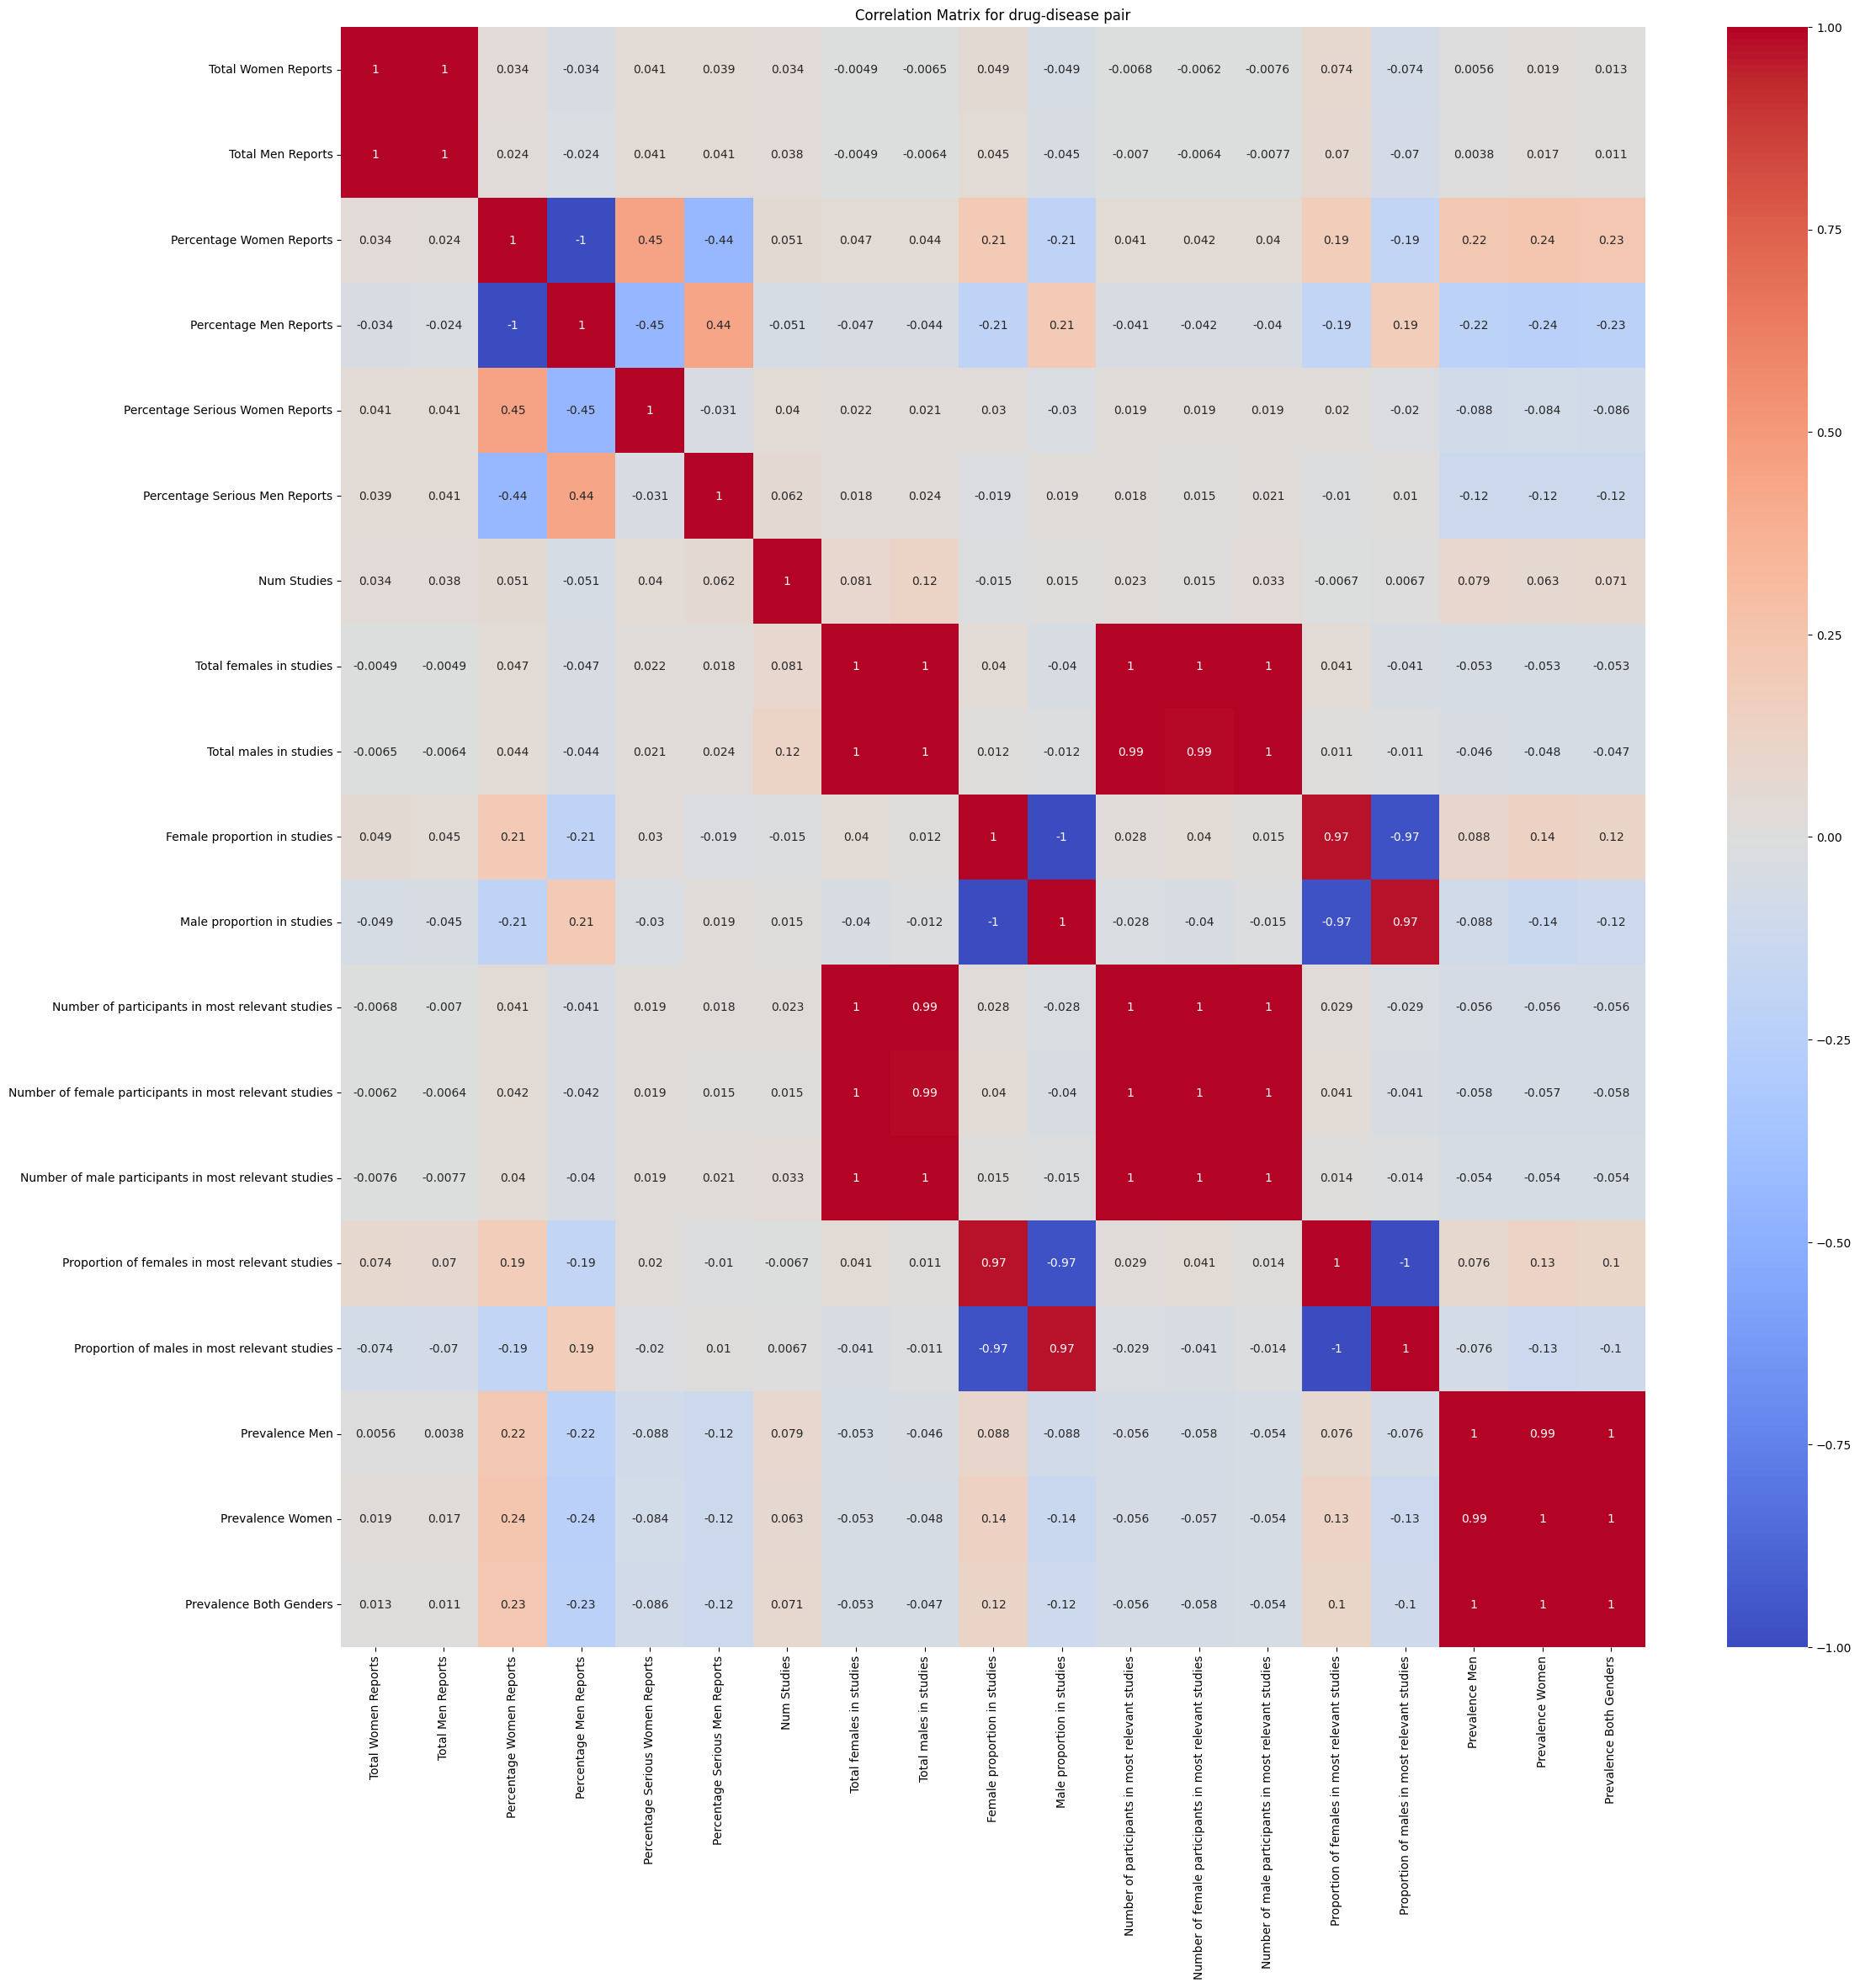

In [ ]:
# Correlation matrix
matrix = data_df.drop(columns=['Indication', 'Drug', 'NCT Numbers', 'Most relevant studies'])
corr_matrix = matrix.corr()
plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for drug-disease pair')
plt.show()